In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt

In [229]:
data = loadmat('./ex5data1.mat')
# data

X,y 为训练集

Xval,yval 为交叉训练集

Xtest,ytest 为测试集

In [230]:
X = data['X']
y = data['y']

X_add_one = np.insert(X,0,1,axis=1)

Xval = data['Xval']
yval = data['yval']

Xtest = data['Xtest']
ytest = data['ytest']

In [231]:
X.shape,y.shape,Xval.shape,yval.shape,Xtest.shape,ytest.shape

((12, 1), (12, 1), (21, 1), (21, 1), (21, 1), (21, 1))

Text(0, 0.5, 'Water flowing out of the dam(y)')

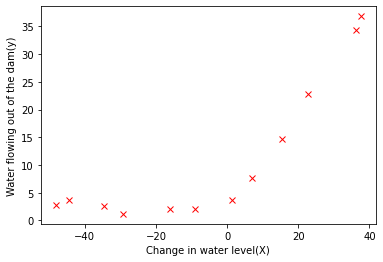

In [232]:
plt.plot(X,y,'rx')
plt.xlabel('Change in water level(X)')
plt.ylabel('Water flowing out of the dam(y)')


## 损失函数(不带正则参数)

In [233]:
def cost(theta,X,y):
    #theta (2,)
    #X (12,2)
    #y (12,1)
    m = X.shape[0]
    # X@theta -> (12,) 不一定代表就是列向量，(12,) - (12,1)可能会被广播成 (12，12)
    inner = X @ theta - y.flatten()  # R(m,)
    #assert inner.shape[1]=='','inner.shape = {}'.format(inner.shape)
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

## 损失函数（带正则参数）

In [234]:
def costReg(theta,X,y,l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [235]:
# theta1 = np.zeros(2)
# costReg(theta1,X_add_one,y,0)

## 梯度函数（不带正则）

In [236]:
def gradient(theta, X ,y):
    #theta (2,1)
    #X (12,2)
    #y (12,1)
    m=len(X)

    h = X @ theta #(12,1)
    grad =(h - y).T @ X
    return grad/m

In [237]:
gradient(np.ones((2,1)),X_add_one,y)

array([[-15.30301567, 598.16741084]])

## 梯度函数（带正则）

In [238]:
def gradient_reg(theta, X, y, l=1):
    m=len(X)
    _theta = theta.copy()
    _theta[0]=0
    reg = (l/m)*_theta
    return gradient(theta, X, y)+reg.flatten()

In [239]:
gradient_reg(np.ones((2,1)), X_add_one, y).shape

(1, 2)

## 高级优化函数进行训练

In [240]:
def linear_trains(X,y,l):
    init_theta = np.zeros(X.shape[1])
    res = opt.minimize(fun=costReg,x0=init_theta,args=(X,y.flatten(),l),method='TNC',jac=gradient_reg)
    #y要转成 (m,)传进去才能保证不出错。否则会报 输出无效值错误
    return res.x

In [241]:
linear_theta = linear_trains(X_add_one,y,1).reshape(2,1)
linear_theta

array([[13.08771416],
       [ 0.367742  ]])

In [242]:
linear_y = X_add_one @ linear_theta
linear_y

array([[ 7.22709892],
       [ 2.3669394 ],
       [26.39613099],
       [26.87516595],
       [-4.5855357 ],
       [ 9.79956457],
       [18.71703246],
       [ 0.3247627 ],
       [13.59856456],
       [-3.23405827],
       [15.66687341],
       [21.45853287]])

Text(0, 0.5, 'Water flowing out of the dam(y)')

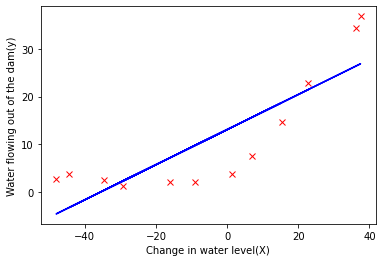

In [243]:
plt.plot(X,y,'rx')
plt.plot(X,linear_y,'b')
plt.xlabel('Change in water level(X)')
plt.ylabel('Water flowing out of the dam(y)')

从图像直接可观察到，用线性回归拟合的效果很差

In [244]:
def get_costValue(X, y, Xval, yval, l):
    x_i = len(X)
    
    cost_train = []
    cost_cv = []
    for i in range(1,x_i+1):
        theta = linear_trains(X[:i], y[:i], 0)

        cost_train.append(costReg(theta, X[:i], y[:i]))
        cost_cv.append(costReg(theta, Xval, yval))

    return cost_train,cost_cv

In [245]:
linear_trains(X_add_one[:10],y[:10],0)

array([13.85366299,  0.37780979])

In [246]:
def plot_error_curve(X, y, Xval, yval):
    error_trains, error_cv = get_costValue(X, y, Xval, yval, 0)

    xx = [i for i in range(1,len(X)+1)]
    plt.plot(xx, error_trains,'b', label = 'error_trains')
    plt.plot(xx, error_cv,'r',label = 'error_cv')
    plt.ylim(0,200)
    plt.grid(True)
    plt.legend(loc=1)

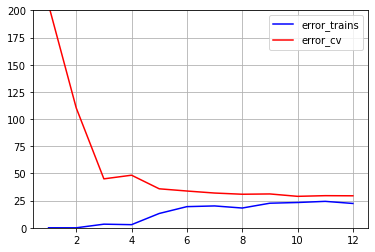

In [247]:
Xval_add_one = np.insert(Xval,0,1,axis=1)
plot_error_curve(X_add_one, y, Xval_add_one, yval)

此图展示了，高偏差/欠拟合的现象。在高偏差/欠拟合的情况下，无论训练集有多大，误差都不会有太大的改观

In [248]:
def genPolyFeather(X, power):
    Xpoly = X.copy()

    for i in range(2,power+1):
        Xpoly = np.insert(Xpoly, Xpoly.shape[1], np.power(Xpoly[:,1],i), axis=1)
    
    return Xpoly

In [249]:
def get_means_std(X):
    means = np.mean(X, axis=0)
    std = np.std(X,axis=0, ddof=1)
    # 而且注意这里是样本标准差而不是总体标准差，使用np.std()时，
    # 将ddof=1则是样本标准差，默认=0是总体标准差。而pandas默认计算样本标准差。
    # ddof 是求方差中  分母 /(N - ddof)
    return means, std

In [276]:
def featureNormalize(X, means, std):
    # 对样本进行标准化，而不是总标准化
    X_norm = X.copy()
    X_norm[:,1:] = (X[:,1:] - means[1:])/std[1:]

    return X_norm

In [322]:
def multi_learn_curve(multi_theta, power):
    #多项式拟合曲线 以及误差分析图

    xx = np.linspace(-75,55,50).reshape(-1,1)
    xx_add_one = np.insert(xx, 0 ,1, axis=1)
    xx_ploy = genPolyFeather(xx_add_one, power)
    xx_means, xx_std = get_means_std(xx_ploy)
    xx_norm = featureNormalize(xx_ploy, xx_means, xx_std)
    yy = xx_norm @ multi_theta.T
    # plt.figure(figsize=(8,2))
    # plt.subplot(121)
    plt.plot(X,y,'rx') #函数里的X是 带偏置项1
    plt.plot(xx, yy, 'g--')
    plt.xlabel('Change in water level(X)')
    plt.ylabel('Water flowing out of the dam(y)')

    # X_ploy =
    # plt.subplot(122)
    # plot_error_curve(xx_ploy, yy, xx_val_ploy,yy_val)

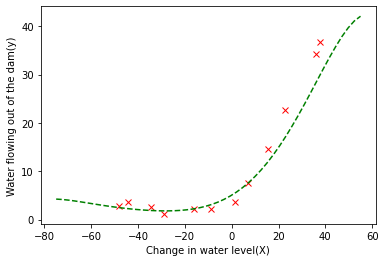

In [323]:
power = 6
l=0
#特征缩放样本，求样本的均值和方差
X_ploy = genPolyFeather(X_add_one,power)
means,std = get_means_std(X_ploy)
X_norm = featureNormalize(X_ploy, means, std)

multi_theta = linear_trains(X_norm, y, l)

multi_learn_curve(multi_theta, power)

In [324]:
y_ploy = X_ploy @ multi_theta.T

Xval_ploy = genPolyFeather(featureNormalize(Xval_add_one,means,std),power)
yval_ploy = Xval_ploy @ multi_theta.T

plot_error_curve(X_ploy, y_ploy, Xval_ploy, yval_ploy)

ValueError: could not broadcast input array from shape (21,6) into shape (21,1)